<a href="https://colab.research.google.com/github/ArielFerreiro/ar-stamp-checker/blob/main/attempt.02/02_BBoxDetectionModel_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the resized BBoxes (224x224 images) we create a model to train it to detect the stamp in a picture.

In [1]:
%load_ext autoreload
%autoreload 2

#### Load the drive to grab the images and labels

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Notebook Imports

In [6]:
import pickle
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from tensorflow.keras.models import save_model, load_model
from sklearn.model_selection import train_test_split

#### Global Params

In [4]:
images_path = 'drive/My Drive/Colab Notebooks/stamps/original/'
results_path = 'drive/My Drive/Colab Notebooks/stamps/results/'
models_path = 'drive/My Drive/Colab Notebooks/stamps/models/'

#### Start

In [5]:
with open(results_path+"bboxes_albu_224.pkl","rb") as f:
    (stamps, bboxes) = pickle.load(f)
with open(results_path+"not_stamps_albu.pkl","rb") as f:
    (not_stamps, ns_bboxes) = pickle.load(f)

In [6]:
stamps.shape, bboxes.shape, not_stamps.shape, ns_bboxes.shape

((1888, 224, 224, 3), (1888, 10), (999, 224, 224, 3), (999, 10))

In [7]:
X = np.append(stamps, not_stamps, axis=0)
y = np.append(bboxes, ns_bboxes, axis=0)

In [8]:
X.shape, y.shape

((2887, 224, 224, 3), (2887, 10))

In [9]:
stamps=0
bboxes=0
not_stamps=0
ns_boxes=0

In [10]:
# retain only the bounding boxes numbers (x,y,delta_x,delta_y)
y = y[:,1:5]
y.shape

(2887, 4)

In [11]:
y[y == ''] = 0.0
y = y.astype(np.float)

In [12]:
y.max(), X.max()

(193.0, 255)

In [13]:
# Normalize the datasets
y = y / y.max()
X = X / X.max()

In [14]:
# datasets creation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.1)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2598, 224, 224, 3), (289, 224, 224, 3), (2598, 4), (289, 4))

#### Model

In [16]:
model = VGG19(include_top=False, input_shape=(224, 224, 3))

80142336/80134624 [==============================] - 3s 0us/step


In [17]:
# no training on first CNN layers
for layer in model.layers:
    layer.trainable = False

In [18]:
model.get_layer(name="block5_pool").output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 7, 7, 512) dtype=float32>

In [19]:
output = keras.layers.Flatten()(model.get_layer(name="block5_pool").output)
output = keras.layers.Dense(255)(output)
output = keras.layers.Activation("relu")(output)
output = keras.layers.Dense(4, activation="sigmoid")(output)

In [20]:
full_model = keras.models.Model(inputs=model.inputs, outputs=output)
#full_model.summary()

In [21]:
# Callbacks
checkpoint_file='checkpoint.pmi-cnn-vgg19.h5'
checkpointer = keras.callbacks.ModelCheckpoint(checkpoint_file, 
                                               monitor="val_mse", 
                                               verbose=1, 
                                               save_best_only=True,
                                               mode='min')

In [22]:
full_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mse"])

In [23]:
history = full_model.fit(X_train, y_train, 
           epochs=20, batch_size=12, 
           validation_data=(X_test, y_test), callbacks=[checkpointer])

Epoch 1/20
217/217 [==============================] - ETA: 0s - loss: 0.4678 - mse: 0.0097
Epoch 00001: val_mse improved from inf to 0.00239, saving model to checkpoint.pmi-cnn-vgg19.h5
217/217 [==============================] - 11s 49ms/step - loss: 0.4678 - mse: 0.0097 - val_loss: 0.3842 - val_mse: 0.0024
Epoch 2/20
217/217 [==============================] - ETA: 0s - loss: 0.4208 - mse: 0.0035
Epoch 00002: val_mse improved from 0.00239 to 0.00129, saving model to checkpoint.pmi-cnn-vgg19.h5
217/217 [==============================] - 10s 45ms/step - loss: 0.4208 - mse: 0.0035 - val_loss: 0.3804 - val_mse: 0.0013
Epoch 3/20
217/217 [==============================] - ETA: 0s - loss: 0.4180 - mse: 0.0023
Epoch 00003: val_mse did not improve from 0.00129
217/217 [==============================] - 9s 43ms/step - loss: 0.4180 - mse: 0.0023 - val_loss: 0.3805 - val_mse: 0.0015
Epoch 4/20
217/217 [==============================] - ETA: 0s - loss: 0.4151 - mse: 0.0011
Epoch 00004: val_mse imp

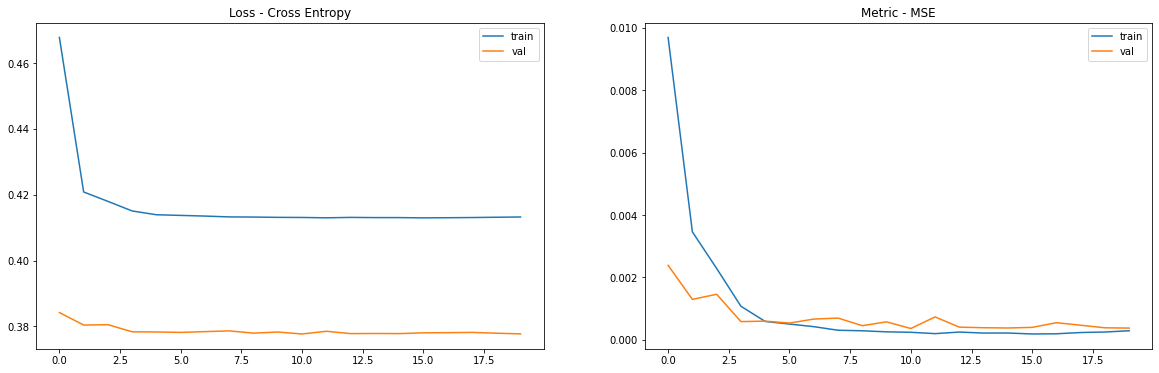

In [24]:
# Check results
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.set_title('Loss - Cross Entropy')
ax1.legend()
ax2.plot(history.history['mse'], label='train')
ax2.plot(history.history['val_mse'], label='val')
ax2.set_title('Metric - MSE')
ax2.legend()
plt.show()

In [25]:
#Save the model
model_name = 'vgg19_bbox_detector_albu.h5'
full_model.save(model_name)

#### Reset the notebook and start again (clean RAM)

In [1]:
from tensorflow.keras.models import save_model, load_model

model_name = 'vgg19_bbox_detector_albu.h5'
checkpoint_file='checkpoint.pmi-cnn-vgg19.h5'

full_model = load_model(model_name, compile=True)
full_model.load_weights(checkpoint_file)


In [ ]:
full_model.evaluate(X, y)

91/91 [==============================] - 14s 153ms/step - loss: 0.4094 - mean_squared_error: 2.1157e-04


[0.40943652391433716, 0.00021157479204703122]

#### Test

In [2]:
def check_predict(path, max_bbox=193):
  i = cv2.imread(path)
  i = cv2.resize(i, dsize=(224, 224))
  i = np.expand_dims(i, axis=0)
  i = i/i.max()
  prediccion = full_model.predict(i)
  bbox = prediccion[0]*max_bbox
  x, y, w, h = bbox
  crop = i[:, int(y):int(y+h), int(x):int(x+w), :]
  fig, ax = plt.subplots(1, 2, figsize=(15, 15))
  ax[0].imshow(i[0])
  ax[0].set_title("Given Image")
  ax[1].imshow(crop[0])
  ax[1].set_title("Estimated Box")
  plt.show()

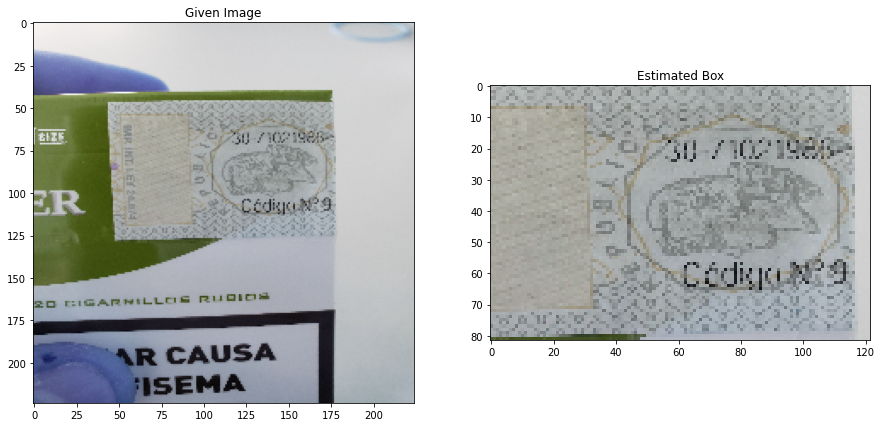

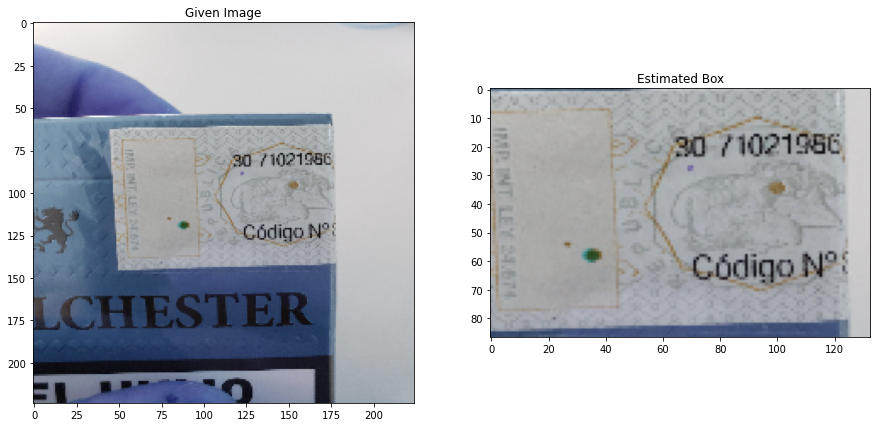

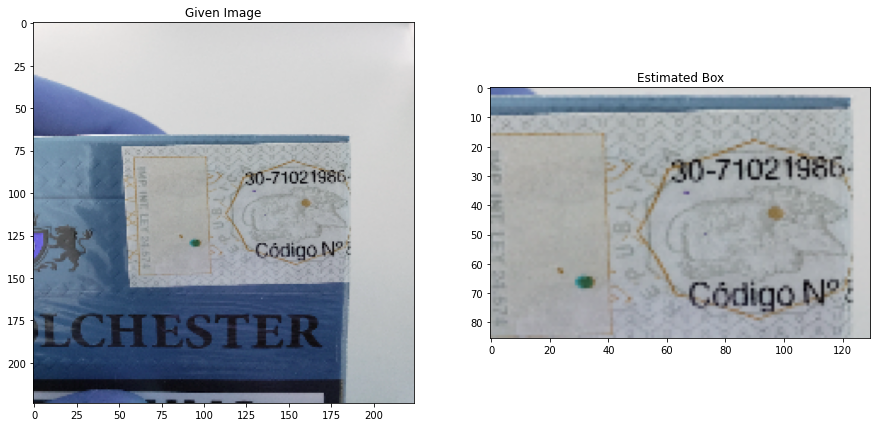

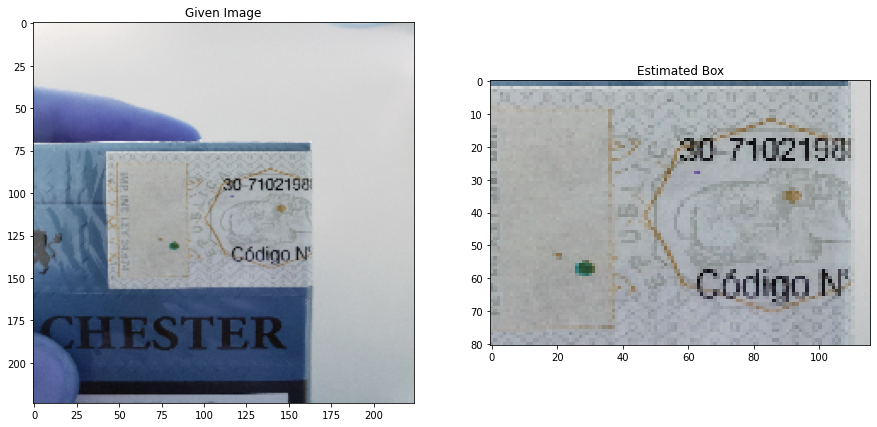

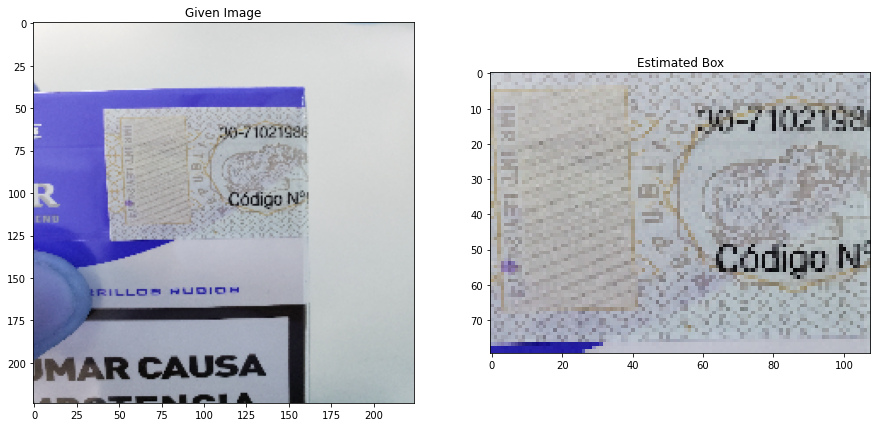

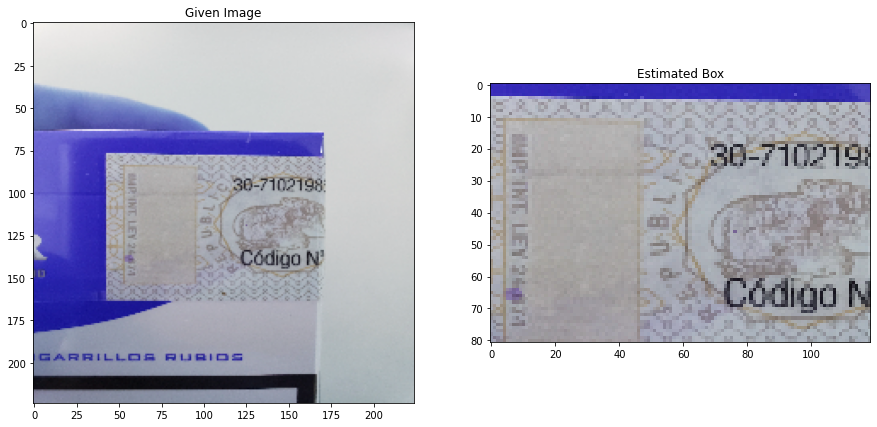

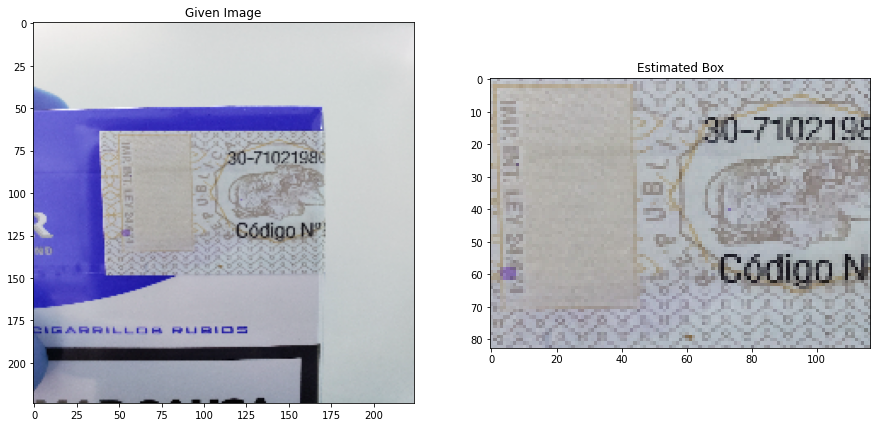

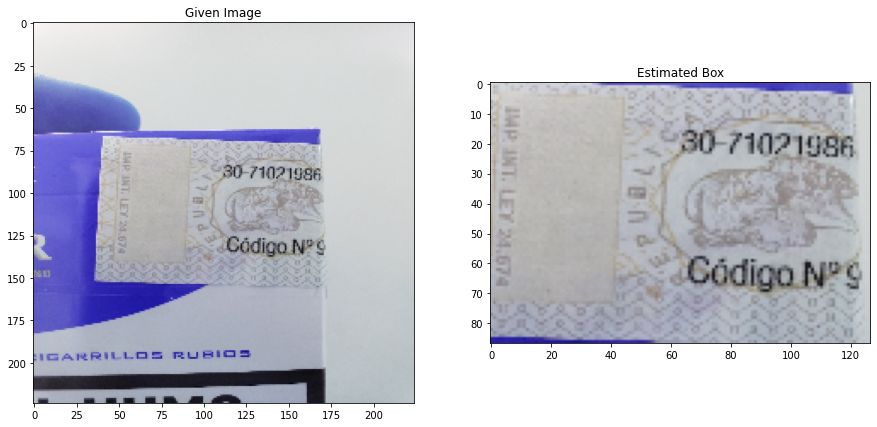

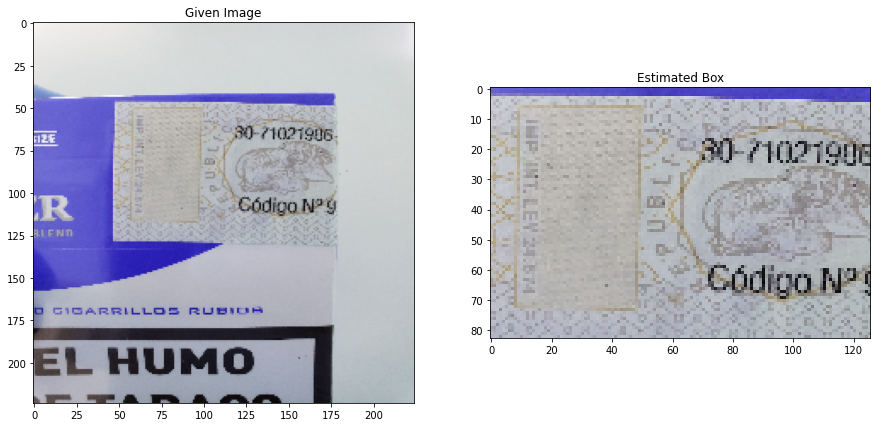

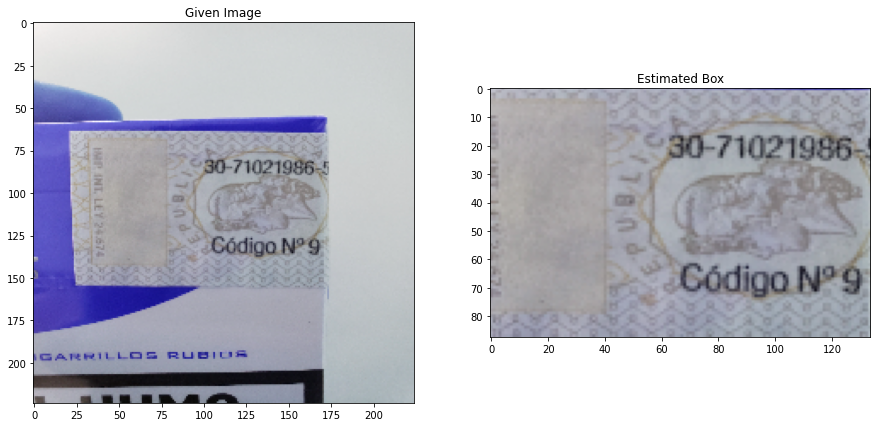

In [7]:
path_img = images_path + 'cft_box/'
for x in range(10):
  check_predict(path_img+os.listdir(path_img)[x])

#### Save Model

In [8]:
model_name = 'vgg19_bbox_detector_albu.h5'

full_model.save(models_path + model_name)
full_model.save_weights(models_path + 'weights_' + model_name)

#### Save model to TFLITE

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(full_model)
tflite_model = converter.convert()

# Save the model.
with open(models_path + 'vgg19_bbox_detector.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpv3et93rq/assets


In [ ]:
#### DONE v1 30/10/2020
#### Auth: Victor Vivas